In [52]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

connct = psycopg2.connect('dbname=WhiskyAdvocate user= postgres password = 23Tiafdtd32 host = 127.0.0.1 port=5432')

#Query the database to recover the needed data for unsupervised learning operations

ds_query = ''' SELECT whiskey_stats.price_usd, whiskey_stats.percent_abv, vector_description.*
                FROM whiskey_stats
                INNER JOIN vector_description
                ON whiskey_stats.whiskey_id = vector_description.whiskey_id;'''

ml_df_full = pd.read_sql(ds_query, connct)

ml_df_full.head()

,price_usd,percent_abv,oak,vanilla,sweet,chocolate,fruit,spice,orange,pepper,...,toasted,tobacco,licorice,nuts,floral,bitter,complex,subtle,coconut,whiskey_id
0,55.0,45.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,40.0,40.0,0,0,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
2,40.0,50.0,2,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,2
3,35.0,45.2,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,65.0,45.0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [53]:
#connct.close()

I am choosing DBSCAN for clustering analysis because there are a lot of points that look like noise points, and a lot of the points look like noise points. Kmeans and agglomerative clustering are bad for irregular shaped clusters. 

In [54]:
#git rid of whiskey_id

ml_df = ml_df_full.drop(['whiskey_id', 'oak'], axis = 1)

#check for missing values
ml_df.isnull().sum()

price_usd       0
percent_abv    11
vanilla         0
sweet           0
chocolate       0
fruit           0
spice           0
orange          0
pepper          0
cinnamon        0
smoke           0
caramel         0
sherry          0
toffee          0
honey           0
apple           0
citrus          0
ginger          0
peat            0
lemon           0
dry             0
leather         0
sugar           0
cherry          0
toasted         0
tobacco         0
licorice        0
nuts            0
floral          0
bitter          0
complex         0
subtle          0
coconut         0
dtype: int64

In [55]:
#loop through the dataframe and replace nulls with the value 40 (default value according to my assumptions when I built this set)

#this loop takes the numeric values from the column and places the in a list
#if it sees a NaN value then it adds the number 40 instead

abv_new = []

for abv in ml_df['percent_abv']:
    if pd.isna(abv) == True:
        abv_new.append(40)
    else:
        abv_new.append(abv)

#abv_new - checking the list showed that it seemed to work

ml_df['percent_abv'] = abv_new

ml_df.isnull().sum()

price_usd      0
percent_abv    0
vanilla        0
sweet          0
chocolate      0
fruit          0
spice          0
orange         0
pepper         0
cinnamon       0
smoke          0
caramel        0
sherry         0
toffee         0
honey          0
apple          0
citrus         0
ginger         0
peat           0
lemon          0
dry            0
leather        0
sugar          0
cherry         0
toasted        0
tobacco        0
licorice       0
nuts           0
floral         0
bitter         0
complex        0
subtle         0
coconut        0
dtype: int64

In [56]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5900 entries, 0 to 5899
Data columns (total 33 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price_usd    5900 non-null   float64
 1   percent_abv  5900 non-null   float64
 2   vanilla      5900 non-null   int64  
 3   sweet        5900 non-null   int64  
 4   chocolate    5900 non-null   int64  
 5   fruit        5900 non-null   int64  
 6   spice        5900 non-null   int64  
 7   orange       5900 non-null   int64  
 8   pepper       5900 non-null   int64  
 9   cinnamon     5900 non-null   int64  
 10  smoke        5900 non-null   int64  
 11  caramel      5900 non-null   int64  
 12  sherry       5900 non-null   int64  
 13  toffee       5900 non-null   int64  
 14  honey        5900 non-null   int64  
 15  apple        5900 non-null   int64  
 16  citrus       5900 non-null   int64  
 17  ginger       5900 non-null   int64  
 18  peat         5900 non-null   int64  
 19  lemon 

I am going to try implementing the DBSCAN clustering alogrythm using scikit learn. I have questions about how well it will work. If it doesn't work, I don't think other clustering algorythms are necessarily likely to work better because of the irregular appearance of some of the clusters when I run t-SNE. An idea I have for refactoring the project is to combine features that seem related - for instance sugar, sweet and honey could all go in the same features, and some of the fruit descriptors could be summed in another feature. This reduceds the dimensionality of the feature space along defensible lines, and may make it easier to spot clusters and patterns.  

In [57]:
#import some necessary things from sklearn

import sklearn
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN

In [58]:
#scale the data using minmaxscaler

scaler = MinMaxScaler().fit(ml_df)

ml_scale = scaler.transform(ml_df)

ml_scale

array([[3.02562224e-04, 4.45151033e-01, 2.50000000e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.07016259e-04, 3.65659777e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.07016259e-04, 5.24642289e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.70713569e-04, 4.45151033e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.25502811e-04, 5.64387917e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.07016259e-04, 4.13354531e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [59]:
#I used min max scaler, which should put all the features between 0 and 1. this means my epsilon (neighborhood) value for 
#DBSCAN needs to be small. I'm going to start with 0.05
#min samples should be kind of large because there are 5900 points in the set. 25 seems like a reasonable value to start. 

cls_1 = DBSCAN(eps = 0.05, min_samples = 25).fit_predict(ml_scale)

cls_1

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [60]:
# my preferred t-SNE parameters were tsne15 = TSNE(random_state=42, perplexity = 40, learning_rate = 1000)
#copying over my helpful t-SNE functions for visualizing my clustering

def tsne_unpack(tsne_array, list1, list2):
    for t in tsne_array:
        list1.append(t[0])
        list2.append(t[1])

def visny_tsne(tsne_instantiation):
    
    ws_tsne_iter = tsne_instantiation.fit_transform(ml_scale)
    
    tsne_x = []
    tsne_y = []
    
    tsne_unpack(ws_tsne_iter, tsne_x, tsne_y)
    
    plt.figure(figsize = (12, 12))
    sns.scatterplot(x = tsne_x, y = tsne_y)
    plt.show()


In [61]:
#constructing a dataframe for t-SNE visualization of clustering
pref_tsne = TSNE(random_state=42, perplexity = 40, learning_rate = 1000)

db_tsne1 = pref_tsne.fit_transform(ml_scale)

pref_tsne_x = []
pref_tsne_y = []

tsne_unpack(db_tsne1, pref_tsne_x, pref_tsne_y)

vis1_dict = {'tSNE_x': pref_tsne_x, 'tSNE_y':pref_tsne_y}

vis_1 = pd.DataFrame(vis1_dict)

vis_1.head()

,tSNE_x,tSNE_y
0,-11.981094,-18.404459
1,-5.953546,-9.642906
2,49.312042,-7.498606
3,-23.973953,-41.524662
4,-22.063446,-46.341320


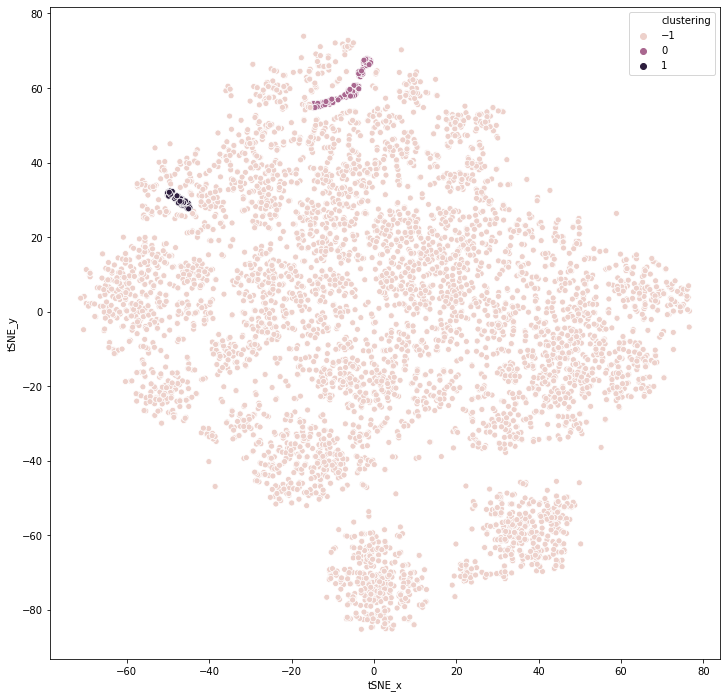

In [62]:
# adding clustering data as a new column, and visualizing

vis_1['clustering'] = cls_1

plt.figure(figsize = (12, 12))
sns.scatterplot(data = vis_1, x = 'tSNE_x', y = 'tSNE_y', hue = 'clustering')

plt.show()

My DBSCAN is finding clusters that look like legitimate clusters, but it thinks most of the space is noise. Cross referencing my hexbin plot from Whiskey_unsuper_learn_w_price_no_oak tells me that the clusters it found are the densest concentrations of points in the plot. This is interesting, and I'll probably come back to cls_1 for some analysis to figure out what is going on in those region of space in the dataset, but further optimization is necessary, be ause I don't consider the rest of the set noise.

In [63]:
# I am going to use the elbow method for deciding my epsilon value
# I used a similar method to Chelsea Pelleriti https://www.youtube.com/watch?v=0V2r7SGP2ZM

from sklearn.neighbors import NearestNeighbors

#set mins argument (what distance do you want nearest neighbors to go by)
# I will start with 25 but may reduce this number
mins = 25

nn = NearestNeighbors(mins + 1)

nn.fit(ml_scale)

distances, neighbors = nn.kneighbors(ml_scale)

distances

C:\Users\gspah\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_neighbors=26 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


array([[0.        , 0.2006309 , 0.20251177, ..., 0.40532525, 0.40651292,
        0.40651295],
       [0.        , 0.45129113, 0.46318197, ..., 0.559017  , 0.55901701,
        0.5590171 ],
       [0.        , 0.05246891, 0.13354531, ..., 0.28683587, 0.28826489,
        0.28990364],
       ...,
       [0.        , 0.42780581, 0.43060703, ..., 0.50460097, 0.50460098,
        0.504601  ],
       [0.        , 0.38990261, 0.40026283, ..., 0.47460882, 0.47672919,
        0.47672919],
       [0.        , 0.46812567, 0.47028055, ..., 0.57006577, 0.57130456,
        0.57183653]])

In [64]:
len(distances)

5900

In [65]:
distances = np.sort(distances[:, mins], axis = 0)

distances

array([0.00954427, 0.01271876, 0.01271976, ..., 1.29483463, 1.35037065,
       1.47212641])

In [66]:
len(distances)

5900

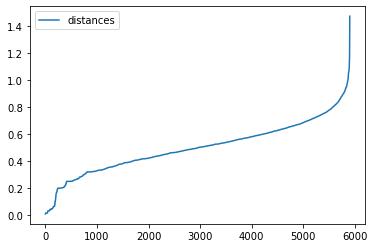

In [67]:
distance_df = pd.DataFrame({'distances':distances})

distance_df.plot(kind = 'line')

C:\Users\gspah\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_neighbors=26 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


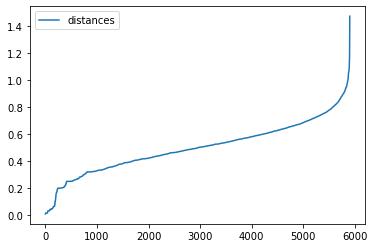

In [68]:
#code out a function to look at how this works for a few different values of mins

def elbow_fxn(min_nearest_neighbors):
    nns = NearestNeighbors(min_nearest_neighbors + 1)
    nns.fit(ml_scale)
    dist, neigh = nns.kneighbors(ml_scale)
    dist = np.sort(dist[:, min_nearest_neighbors], axis = 0)
    dist_df = pd.DataFrame({'distances': dist})
    dist_df.plot(kind = 'line')
    plt.show()

elbow_fxn(25)


C:\Users\gspah\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_neighbors=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


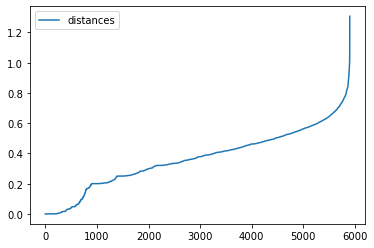

In [69]:
elbow_fxn(2)

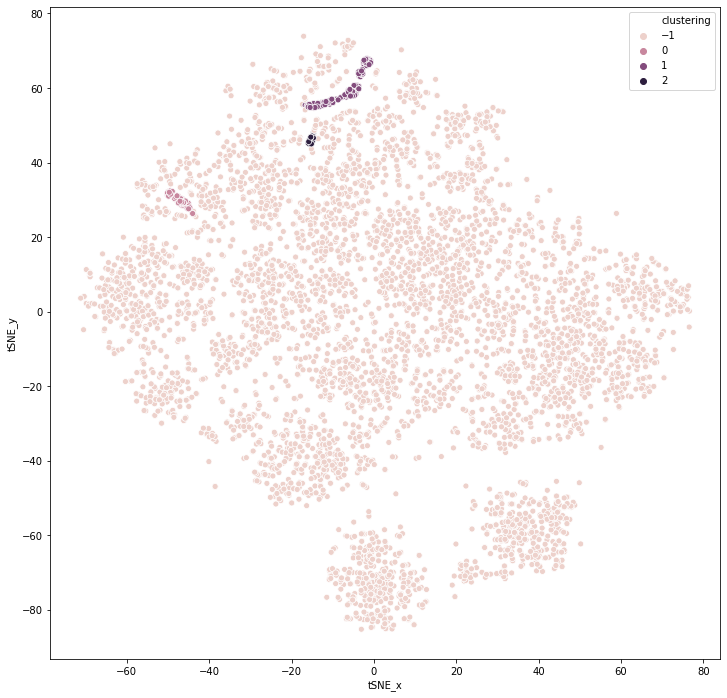

In [70]:
#elbow function is a little hard to interpret. I'm going to try a few new values for clustering, though, 
#based on the scales I'm seeing. 

cls_2 = DBSCAN(eps = 0.1, min_samples = 25).fit_predict(ml_scale)

#write a function to make visualizing clustering results on the t-SNE picture really easy

def cluster_vis(dbscan_array):
    vis_1['clustering'] = dbscan_array

    plt.figure(figsize = (12, 12))
    sns.scatterplot(data = vis_1, x = 'tSNE_x', y = 'tSNE_y', hue = 'clustering')

    plt.show()

cluster_vis(cls_2)
    

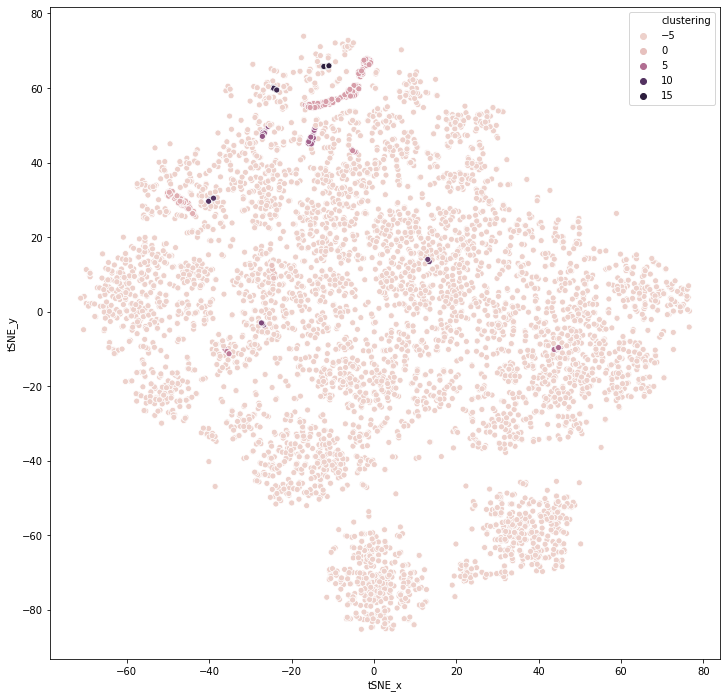

In [71]:
cls_3  = DBSCAN(eps = 0.1, min_samples = 10).fit_predict(ml_scale) 

cluster_vis(cls_3)

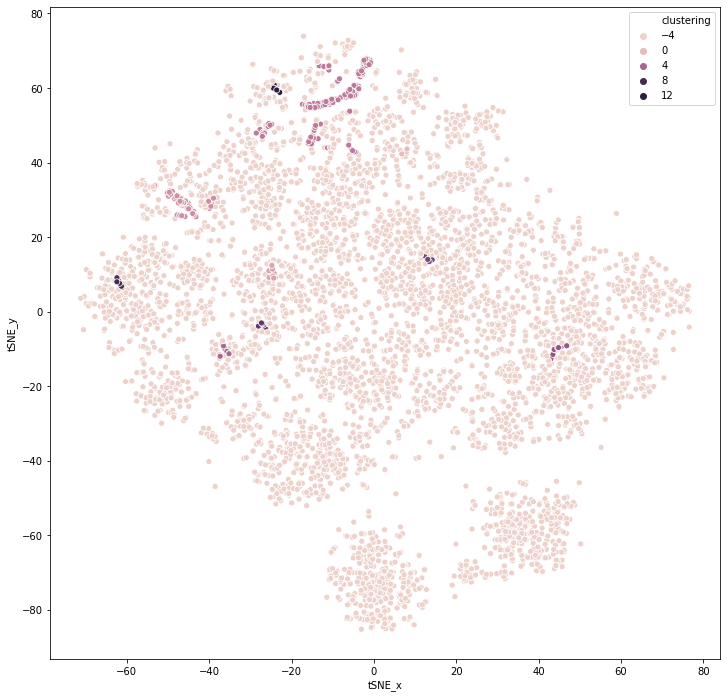

In [72]:
cls_4 = DBSCAN(eps = 0.2, min_samples = 10).fit_predict(ml_scale)

cluster_vis(cls_4)

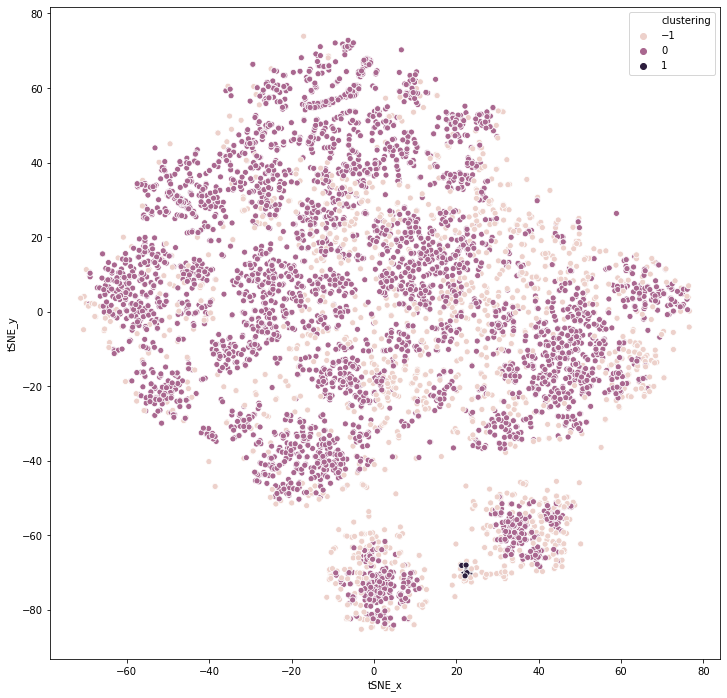

In [73]:
cls_5 = DBSCAN(eps = 0.5, min_samples = 10).fit_predict(ml_scale)

cluster_vis(cls_5)

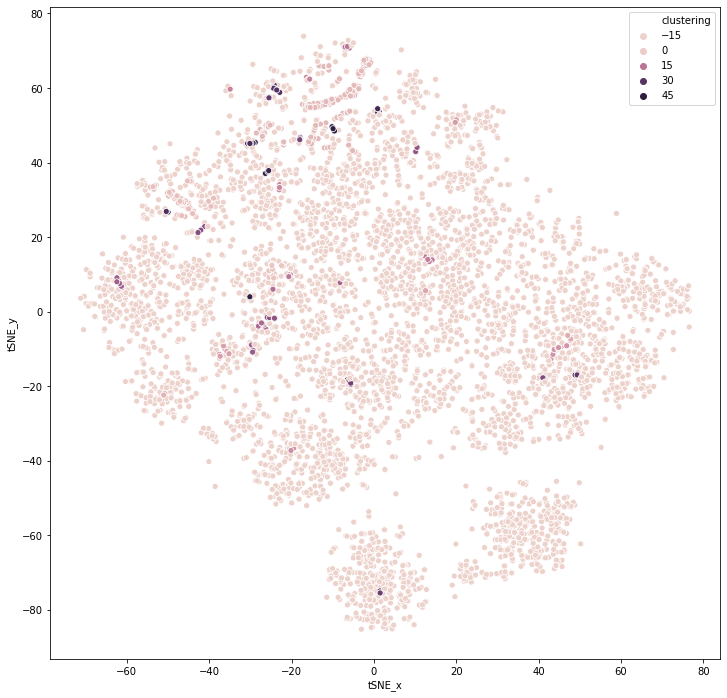

In [74]:
cls_6 = DBSCAN(eps = 0.2, min_samples = 5).fit_predict(ml_scale)

cluster_vis(cls_6)

In [75]:
cls_6

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [76]:
vis_1.head()

,tSNE_x,tSNE_y,clustering
0,-11.981094,-18.404459,-1
1,-5.953546,-9.642906,-1
2,49.312042,-7.498606,-1
3,-23.973953,-41.524662,-1
4,-22.063446,-46.341320,-1


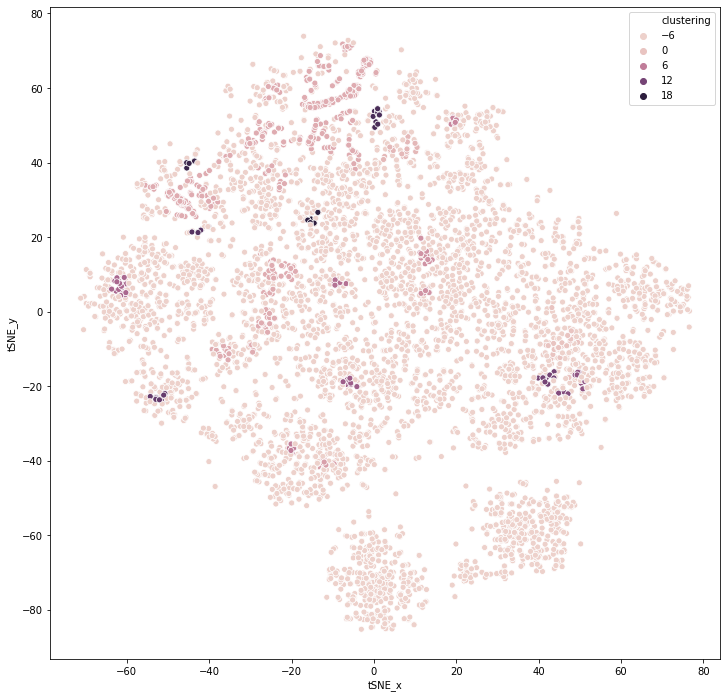

In [77]:
cls_7 = DBSCAN(eps = 0.25, min_samples = 10).fit_predict(ml_scale)

cluster_vis(cls_7)

OK so this isn't going expecially well, but it is interesting that a couple clusters that show up in t-SNE are actually identified in my initial conditions. I want to investigate these clusters just to see what is driving the clustering

In [78]:
ds_query2 = ''' SELECT whiskey_stats.name, whiskey_stats.price_usd, whiskey_stats.percent_abv, vector_description.*
                FROM whiskey_stats
                INNER JOIN vector_description
                ON whiskey_stats.whiskey_id = vector_description.whiskey_id;'''

ml_df_full2 = pd.read_sql(ds_query2, connct)

ml_df_full2.head()

,name,price_usd,percent_abv,oak,vanilla,sweet,chocolate,fruit,spice,orange,...,toasted,tobacco,licorice,nuts,floral,bitter,complex,subtle,coconut,whiskey_id
0,Spirit Hound Single Barrel Straight Malt (Barr...,55.0,45.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Dogfish Head Straight Malt 40%,40.0,40.0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,1
2,Balcones Texas Bock Straight Malt Whiskey 50%,40.0,50.0,2,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,2
3,Woodford Reserve Straight Malt Whiskey 45.2%,35.0,45.2,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3
4,Spirit Hound Colorado Honey Malt (Barrel No. 4...,65.0,45.0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [79]:
#add clusters from the first try

ml_df_full2['cluster'] = cls_1

ml_df_full2.head()

,name,price_usd,percent_abv,oak,vanilla,sweet,chocolate,fruit,spice,orange,...,tobacco,licorice,nuts,floral,bitter,complex,subtle,coconut,whiskey_id,cluster
0,Spirit Hound Single Barrel Straight Malt (Barr...,55.0,45.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
1,Dogfish Head Straight Malt 40%,40.0,40.0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,1,-1
2,Balcones Texas Bock Straight Malt Whiskey 50%,40.0,50.0,2,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,2,-1
3,Woodford Reserve Straight Malt Whiskey 45.2%,35.0,45.2,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,3,-1
4,Spirit Hound Colorado Honey Malt (Barrel No. 4...,65.0,45.0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,4,-1


In [83]:
c0_df = ml_df_full2[ml_df_full2['cluster'] == 0]

pd.set_option('display.max_columns', 40)

c0_df

,name,price_usd,percent_abv,oak,vanilla,sweet,chocolate,fruit,spice,orange,pepper,cinnamon,smoke,caramel,sherry,toffee,honey,apple,citrus,ginger,peat,lemon,dry,leather,sugar,cherry,toasted,tobacco,licorice,nuts,floral,bitter,complex,subtle,coconut,whiskey_id,cluster
103,Southern Coast Single Malt Cask 3 46%,107.0,46.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,103,0
104,Overeem Port Cask Matured #26 43%,235.0,43.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,104,0
110,Old Hobart Overeem Port Cask 55%,186.0,55.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,110,0
131,Belgian Owl 4 year old cask L140211 46%,68.0,46.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,131,0
313,Douglas Laing Big Peat Christmas 2013 54.9%,76.0,54.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,313,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5796,Omar Sherry Cask-Finished Single Malt 46%,90.0,46.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5796,0
5801,Old Ballantruan 50%,60.0,50.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5801,0
5843,Low Gap Whiskey (American Craft Whiskey Distil...,40.0,42.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5843,0
5856,Catoctin Creek Mosby’s Spirit 40%,39.0,40.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5856,0


Cluster zero appears to consist of whiskeys that don't contain any of the most common flavor descriptors. I guess we could call this the sui generis cluster. There are 126 whiskeys like this. 

In [86]:
c1_df = ml_df_full2[ml_df_full2['cluster'] == 1]

print(len(c1_df))

c1_df

57


,name,price_usd,percent_abv,oak,vanilla,sweet,chocolate,fruit,spice,orange,pepper,cinnamon,smoke,caramel,sherry,toffee,honey,apple,citrus,ginger,peat,lemon,dry,leather,sugar,cherry,toasted,tobacco,licorice,nuts,floral,bitter,complex,subtle,coconut,whiskey_id,cluster
65,Rogue Dead Guy American Whiskey 40%,40.0,40.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,65,1
123,Belgian Owl Cask L170711 4 year old 2012 46%,80.0,46.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,1
288,Tullamore Dew 12 Year Old Special Reserve 40%,40.0,40.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,288,1
440,Timorous Beastie 46.8%,59.0,46.8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,440,1
756,Monarch of The Glen 8 year old 40%,15.0,40.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,756,1
772,Islay Mist 8 year old 40%,24.0,40.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,772,1
1443,Abraham Bowman Double Barrel Bourbon 50%,70.0,50.0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1443,1
1463,Buckhorn 40%,17.0,40.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1463,1
1567,Spirit of America Bourbon 43%,40.0,43.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1567,1
1592,Jim Beam Signature Craft Whole Rolled Oat 45%,50.0,45.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1592,1


This cluster has 57 whiskeys. These whiskeys all have similar ABVs and they all have 'sweet' as the only common descriptor, and the descriptor only occurs once. You could call this the 'bland sweet' cluster, but I think my model would benefit from reengineering features. I want to combine similar words in the features, add more words and have fewer overall dimensions. It might be useful to take the number of instances a type of description is mentioned as a ratio of the overall number of words in the review.

In [87]:
connct.close()